# Modeling perturb-seq data + uncertainities 

In [79]:
# Load the autoreload extension
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import nocap.utility as utility
import networkx as nx
import matplotlib.pyplot as plt
import tellurium as te

import numpy as np
import pandas as pd
import torch

import torch
import pyro
import pyro.distributions as dist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy Model

A --> B; A activates B

C --| B; C represses B

B --> D; B activates D

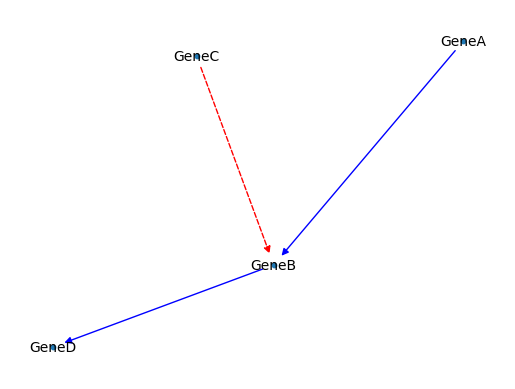

In [2]:
# create toy network
abcd_dag = nx.DiGraph()
abcd_dag.add_node('GeneA', value=10.0)  
abcd_dag.add_node('GeneB', value=0.0)
abcd_dag.add_node('GeneC', value=10.0)  
abcd_dag.add_node('GeneD', value=0.0)
abcd_dag.add_edge('GeneA', 'GeneB', interaction_type='activation')
abcd_dag.add_edge('GeneC', 'GeneB', interaction_type='repression')
abcd_dag.add_edge('GeneB', 'GeneD', interaction_type='activation')


# plot graph
# plot the network
G = abcd_dag
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=10)
activation_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'activation']
repression_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'repression']
nx.draw_networkx_edges(G, pos, edgelist=activation_edges, edge_color='blue', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=repression_edges, edge_color='red', arrows=True, style='dashed')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.axis('off')
plt.show()



## Mass action kinetics



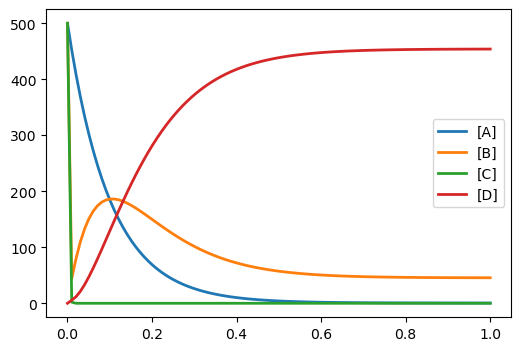

In [41]:
antimony_str = """
model GeneRegulationNetwork()
  // Compartment
  compartment test_compartment = 1  // volume in arbitrary units

  // Species
  var A, B, C, D in test_compartment

  // Initial counts
  substanceOnly species A = 500
  substanceOnly species B = 500
  substanceOnly species C = 500
  substanceOnly species D = 0.0

  // Parameters (rate constants)
  const k1 = 1e1    // Adjusted rate
  const k1_rev = 1e-1
  const k2 = 1e1
  const k2_rev = 1e-2
  const k3 = 1e1
  const k3_rev = 1e0

  // Reaction flux (mol/L/s)
  J1: A -> B; k1*A/test_compartment - k1_rev*B/test_compartment
  J2: B + C -> ; k2*B*C/test_compartment - k2_rev/test_compartment
  J3: B -> D; k3*B/test_compartment - k3_rev*D/test_compartment
end
"""

# Load the model into Tellurium
model = te.loada(antimony_str)

# Simulate the model
result = model.simulate(0, 1, 100)

# Plot the results
model.plot(result)


## check model stability

if all eigenvalues are not positive --> model is locally stable

In [42]:
jacobian = np.array(model.getFullJacobian().tolist())
eigenvalues = np.linalg.eigvals(jacobian)
display(eigenvalues)

array([-1.16465817e+01, -9.45341335e+00, -1.12617194e-16, -4.55548419e+02])

## get steady-state values

In [43]:
ss_values = model.getSteadyStateValuesNamedArray()
display(ss_values)

         [A],     [B],       [C],     [D]
 [[ 0.454133, 45.4133, 2.202e-05, 454.133]]

## initialize model w/ steady state values

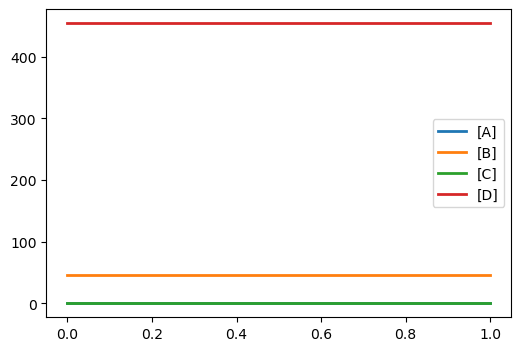

In [44]:
model.resetToOrigin() 

for i, species in enumerate(ss_values.colnames):
    reformatted_name = species.strip('[]')
    model.setInitConcentration(reformatted_name,ss_values[species][0]) 

ss_result = model.simulate(0, 1, 100)
model.plot(ss_result)

## simulate SDEs
assume units are counts

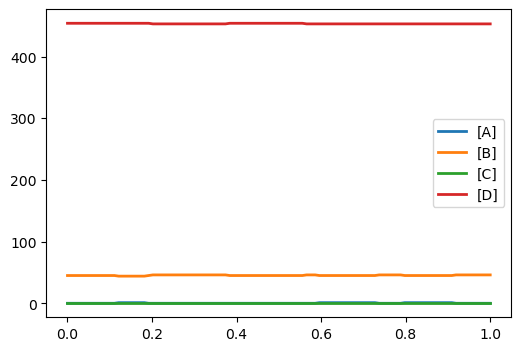

         time, [A], [B], [C], [D]
 [[         0,   0,  45,   0, 454],
  [  0.010101,   0,  45,   0, 454],
  [  0.020202,   0,  45,   0, 454],
  [  0.030303,   0,  45,   0, 454],
  [  0.040404,   0,  45,   0, 454],
  [ 0.0505051,   0,  45,   0, 454],
  [ 0.0606061,   0,  45,   0, 454],
  [ 0.0707071,   0,  45,   0, 454],
  [ 0.0808081,   0,  45,   0, 454],
  [ 0.0909091,   0,  45,   0, 454],
  [   0.10101,   0,  45,   0, 454],
  [  0.111111,   0,  45,   0, 454],
  [  0.121212,   1,  44,   0, 454],
  [  0.131313,   1,  44,   0, 454],
  [  0.141414,   1,  44,   0, 454],
  [  0.151515,   1,  44,   0, 454],
  [  0.161616,   1,  44,   0, 454],
  [  0.171717,   1,  44,   0, 454],
  [  0.181818,   1,  44,   0, 454],
  [  0.191919,   0,  45,   0, 454],
  [   0.20202,   0,  46,   0, 453],
  [  0.212121,   0,  46,   0, 453],
  [  0.222222,   0,  46,   0, 453],
  [  0.232323,   0,  46,   0, 453],
  [  0.242424,   0,  46,   0, 453],
  [  0.252525,   0,  46,   0, 453],
  [  0.262626,   0,  46,   0, 

In [51]:
model.resetToOrigin() 
model.integrator = 'gillespie'
model.integrator.seed = 1234
model.steadyState()

for i, species in enumerate(ss_values.colnames):
    reformatted_name = species.strip('[]')
    model.setInitConcentration(reformatted_name,int(ss_values[species][0])) 

ss_sde_result = model.simulate(0, 1, 100)
model.plot(ss_sde_result)
display(ss_sde_result)

## pick "observation" samples

randomly choose N samples

In [165]:
col_names = [f'gene{name.strip("[]")}' for name in ss_sde_result.colnames]
N_samples = 10

random_indices = np.random.choice(ss_sde_result.shape[0], N_samples, replace=False)
random_sde_samples = ss_sde_result[random_indices]
sde_samples_df = pd.DataFrame(random_sde_samples, columns=col_names)

clean_sde_samples_df = sde_samples_df.drop(columns='genetime')
clean_sde_samples_df

,geneA,geneB,geneC,geneD
0,0.0,46.0,0.0,453.0
1,0.0,46.0,0.0,453.0
2,0.0,45.0,0.0,454.0
3,1.0,45.0,0.0,453.0
4,1.0,44.0,0.0,454.0
5,0.0,46.0,0.0,453.0
6,0.0,45.0,0.0,454.0
7,0.0,46.0,0.0,453.0
8,1.0,45.0,0.0,453.0
9,1.0,45.0,0.0,453.0


## convert data into a tensor

In [166]:
sde_samples_tensor = torch.tensor(clean_sde_samples_df.values, dtype=torch.float)
sde_samples_tensor

tensor([[  0.,  46.,   0., 453.],
        [  0.,  46.,   0., 453.],
        [  0.,  45.,   0., 454.],
        [  1.,  45.,   0., 453.],
        [  1.,  44.,   0., 454.],
        [  0.,  46.,   0., 453.],
        [  0.,  45.,   0., 454.],
        [  0.,  46.,   0., 453.],
        [  1.,  45.,   0., 453.],
        [  1.,  45.,   0., 453.]])

## apply biological noise uncertainty

add Gaussian white noise

x_new = x_old + epsilon

epsilon ~ Normal(mu,sigma)

mu and sigma are user-defined variables

Needs to be positive so instead use log-normal distribution!

In [204]:
def apply_biological_noise_process(tensor, mean=0.0, std=1.0):
    noise = dist.LogNormal(mean, std).sample(tensor.size())
    return tensor + noise

bio_noise_mean = 0.0
bio_noise_std = 1.0

bio_noise_tensor = apply_biological_noise_process(sde_samples_tensor,bio_noise_std)
bio_noise_df = pd.DataFrame(bio_noise_tensor.numpy(), columns=clean_sde_samples_df.columns)

display(bio_noise_tensor)
display(bio_noise_df)

tensor([[1.5171e+00, 4.8664e+01, 5.3503e+00, 4.5555e+02],
        [4.2908e+00, 4.7843e+01, 6.1818e-01, 4.5502e+02],
        [4.3702e+00, 5.7588e+01, 1.7446e+00, 4.5613e+02],
        [6.7507e+00, 4.8351e+01, 5.5612e+00, 4.5669e+02],
        [3.3516e+00, 4.6801e+01, 1.0359e+00, 4.5739e+02],
        [6.7676e-01, 5.2586e+01, 4.3495e+00, 4.5922e+02],
        [4.0657e+00, 5.2018e+01, 2.9503e+00, 4.5716e+02],
        [1.3473e+00, 4.7024e+01, 3.6484e+00, 5.4774e+02],
        [1.0087e+01, 4.9891e+01, 3.9641e+00, 4.5380e+02],
        [8.0892e+00, 5.3449e+01, 1.8873e-01, 4.5430e+02]])

,geneA,geneB,geneC,geneD
0,1.517062,48.663879,5.350313,455.545746
1,4.290792,47.842854,0.618179,455.017151
2,4.370235,57.588322,1.744636,456.134125
3,6.750653,48.351299,5.561203,456.691406
4,3.351602,46.800571,1.035914,457.389130
5,0.676757,52.585560,4.349517,459.218323
6,4.065665,52.018093,2.950304,457.157166
7,1.347338,47.023750,3.648405,547.738342
8,10.086681,49.891479,3.964062,453.796234
9,8.089197,53.449467,0.188725,454.304169


## apply outlier uncertainty

for a given cell and gene: x_new = x_old * scale_factor * binary_indicator + (1-binary_indicator) * x_old

Binary_indicator  ~ bernouli(pi)

Scale_factor ~ log normal (mu, sigma)

pi, mu, and sigma are user-defined parameters

In [205]:
def apply_outlier_process(tensor, pi, mu, sigma):
    binary_indicators = dist.Bernoulli(pi).sample(tensor.size())
    scale_factors = dist.LogNormal(mu, sigma).sample(tensor.size())
    updated_tensor = tensor * scale_factors * binary_indicators + (1 - binary_indicators) * tensor
    return updated_tensor

outlier_pi = 0.2
outlier_mu = 0.0
outlier_sigma = 1.0

outliers_tensor = apply_outlier_process(bio_noise_tensor,outlier_pi, outlier_mu, outlier_sigma)
outliers_df = pd.DataFrame(outliers_tensor.numpy(), columns=clean_sde_samples_df.columns)

display(outliers_tensor)
display(outliers_df)


tensor([[1.5171e+00, 4.8664e+01, 5.3503e+00, 3.0649e+02],
        [4.2908e+00, 4.7843e+01, 6.1818e-01, 4.5502e+02],
        [4.3702e+00, 9.7107e+01, 1.7446e+00, 1.0325e+02],
        [6.7507e+00, 3.7161e+01, 5.5612e+00, 8.6477e+01],
        [3.1110e+00, 4.6801e+01, 5.6515e-01, 4.5739e+02],
        [6.7676e-01, 5.2586e+01, 4.3495e+00, 4.5922e+02],
        [4.0657e+00, 5.2018e+01, 1.5733e+00, 4.5716e+02],
        [1.3473e+00, 4.7024e+01, 3.6484e+00, 5.4774e+02],
        [1.0087e+01, 4.9891e+01, 3.9641e+00, 4.5380e+02],
        [8.0892e+00, 5.3449e+01, 1.8873e-01, 1.3538e+03]])

,geneA,geneB,geneC,geneD
0,1.517062,48.663879,5.350313,306.488922
1,4.290792,47.842854,0.618179,455.017151
2,4.370235,97.106552,1.744636,103.245987
3,6.750653,37.160740,5.561203,86.476753
4,3.110955,46.800571,0.565151,457.389130
5,0.676757,52.585560,4.349517,459.218323
6,4.065665,52.018093,1.573294,457.157166
7,1.347338,47.023750,3.648405,547.738342
8,10.086681,49.891479,3.964062,453.796234
9,8.089197,53.449467,0.188725,1353.839478


## apply library size uncertainty 
for a given cell (row): x_new = L*x_old/sum(x)

L ~ lognormal(mu,sigma)

x is a list gene expression for all genes in the cell sample (x)

mu and sigma are user-defined. 

In [252]:
def apply_library_size_process(tensor, mu, sigma):
    row_sums = tensor.sum(dim=1, keepdim=True)
    L = dist.LogNormal(mu, sigma).sample([tensor.size(0), 1])
    scaled_tensor = (L * tensor) / row_sums
    return scaled_tensor

library_mu = 5.0
library_sigma = 1.0

library_size_tensor = apply_library_size_process(outliers_tensor, library_mu, library_sigma)
library_size_df = pd.DataFrame(library_size_tensor.numpy(), columns=clean_sde_samples_df.columns)

display(library_size_tensor)
display(library_size_df)


tensor([[3.6726e+00, 1.1781e+02, 1.2952e+01, 7.4197e+02],
        [3.2784e+00, 3.6555e+01, 4.7232e-01, 3.4766e+02],
        [2.4811e+00, 5.5129e+01, 9.9046e-01, 5.8615e+01],
        [9.1312e+00, 5.0265e+01, 7.5223e+00, 1.1697e+02],
        [6.8864e-01, 1.0360e+01, 1.2510e-01, 1.0125e+02],
        [1.2033e+00, 9.3498e+01, 7.7335e+00, 8.1650e+02],
        [1.0887e+00, 1.3929e+01, 4.2128e-01, 1.2241e+02],
        [1.2334e-01, 4.3047e+00, 3.3399e-01, 5.0142e+01],
        [3.8355e+00, 1.8971e+01, 1.5073e+00, 1.7256e+02],
        [4.6530e+00, 3.0745e+01, 1.0856e-01, 7.7875e+02]])

,geneA,geneB,geneC,geneD
0,3.672615,117.809097,12.952430,741.970886
1,3.278400,36.554558,0.472323,347.658051
2,2.481064,55.129204,0.990463,58.614674
3,9.131183,50.264988,7.522288,116.971657
4,0.688641,10.359779,0.125102,101.247711
5,1.203286,93.498032,7.733517,816.498108
6,1.088654,13.928769,0.421277,122.411949
7,0.123340,4.304728,0.333988,50.141994
8,3.835469,18.971277,1.507338,172.556396
9,4.653025,30.744915,0.108557,778.748352


## apply dropout uncertainty 

for a given cell and gene: x_new = binary_indicator * x_old

binary_indicator ~ bernouli(pi)

pi = 1/(1+exp(-k*(Y-y_0)))

Y = log (x_old + 1)

y_0 = qth percentile of Y

k and q are two user-defined parameters.

potentially better approach: zero inflated negative binomial (ZINB)

In [256]:
def apply_dropout_process(tensor, k, q):
    Y = torch.log(tensor + 1)
    y_0 = torch.quantile(Y, q)
    pi = 1 / (1 + torch.exp(-k * (Y - y_0)))
    binary_indicators = dist.Bernoulli(pi).sample()
    updated_tensor = binary_indicators * tensor
    return updated_tensor


dropout_k = 1.0     # Logistic function parameter
dropout_q = 0.5     # Percentile for y_0 (median)

dropout_tensor = apply_dropout_process(library_size_tensor,dropout_k,dropout_q)
dropout_df = pd.DataFrame(dropout_tensor.numpy(), columns=clean_sde_samples_df.columns)

display(dropout_tensor)
display(dropout_df)

tensor([[  0.0000, 117.8091,  12.9524, 741.9709],
        [  0.0000,  36.5546,   0.0000, 347.6581],
        [  2.4811,  55.1292,   0.0000,   0.0000],
        [  0.0000,  50.2650,   7.5223, 116.9717],
        [  0.0000,   0.0000,   0.0000, 101.2477],
        [  0.0000,  93.4980,   7.7335, 816.4981],
        [  0.0000,  13.9288,   0.0000, 122.4119],
        [  0.0000,   4.3047,   0.0000,  50.1420],
        [  0.0000,  18.9713,   1.5073, 172.5564],
        [  0.0000,  30.7449,   0.0000, 778.7484]])

,geneA,geneB,geneC,geneD
0,0.000000,117.809097,12.952430,741.970886
1,0.000000,36.554558,0.000000,347.658051
2,2.481064,55.129204,0.000000,0.000000
3,0.000000,50.264988,7.522288,116.971657
4,0.000000,0.000000,0.000000,101.247711
5,0.000000,93.498032,7.733517,816.498108
6,0.000000,13.928769,0.000000,122.411949
7,0.000000,4.304728,0.000000,50.141994
8,0.000000,18.971277,1.507338,172.556396
9,0.000000,30.744915,0.000000,778.748352


## apply UMI count uncertainty

for a given cell and gene: UC ~ poisson(x_new)

potentially better approach: over dispersed distribution

In [257]:
def apply_umi_count_process(tensor):
    umi_counts = dist.Poisson(tensor).sample()
    return umi_counts

umi_count_tensor = apply_umi_count_process(dropout_tensor)
umi_count_df = pd.DataFrame(umi_count_tensor.numpy(), columns=clean_sde_samples_df.columns)

display(umi_count_tensor)
display(umi_count_df)

tensor([[  0., 110.,  14., 699.],
        [  0.,  31.,   0., 383.],
        [  1.,  55.,   0.,   0.],
        [  0.,  57.,   4., 107.],
        [  0.,   0.,   0., 102.],
        [  0.,  80.,   9., 799.],
        [  0.,  19.,   0., 118.],
        [  0.,   6.,   0.,  51.],
        [  0.,  17.,   1., 201.],
        [  0.,  32.,   0., 776.]])

,geneA,geneB,geneC,geneD
0,0.0,110.0,14.0,699.0
1,0.0,31.0,0.0,383.0
2,1.0,55.0,0.0,0.0
3,0.0,57.0,4.0,107.0
4,0.0,0.0,0.0,102.0
5,0.0,80.0,9.0,799.0
6,0.0,19.0,0.0,118.0
7,0.0,6.0,0.0,51.0
8,0.0,17.0,1.0,201.0
9,0.0,32.0,0.0,776.0


## visualization

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_96238/2485433330.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_96238/2485433330.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_96238/2485433330.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_96238/2485433330.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



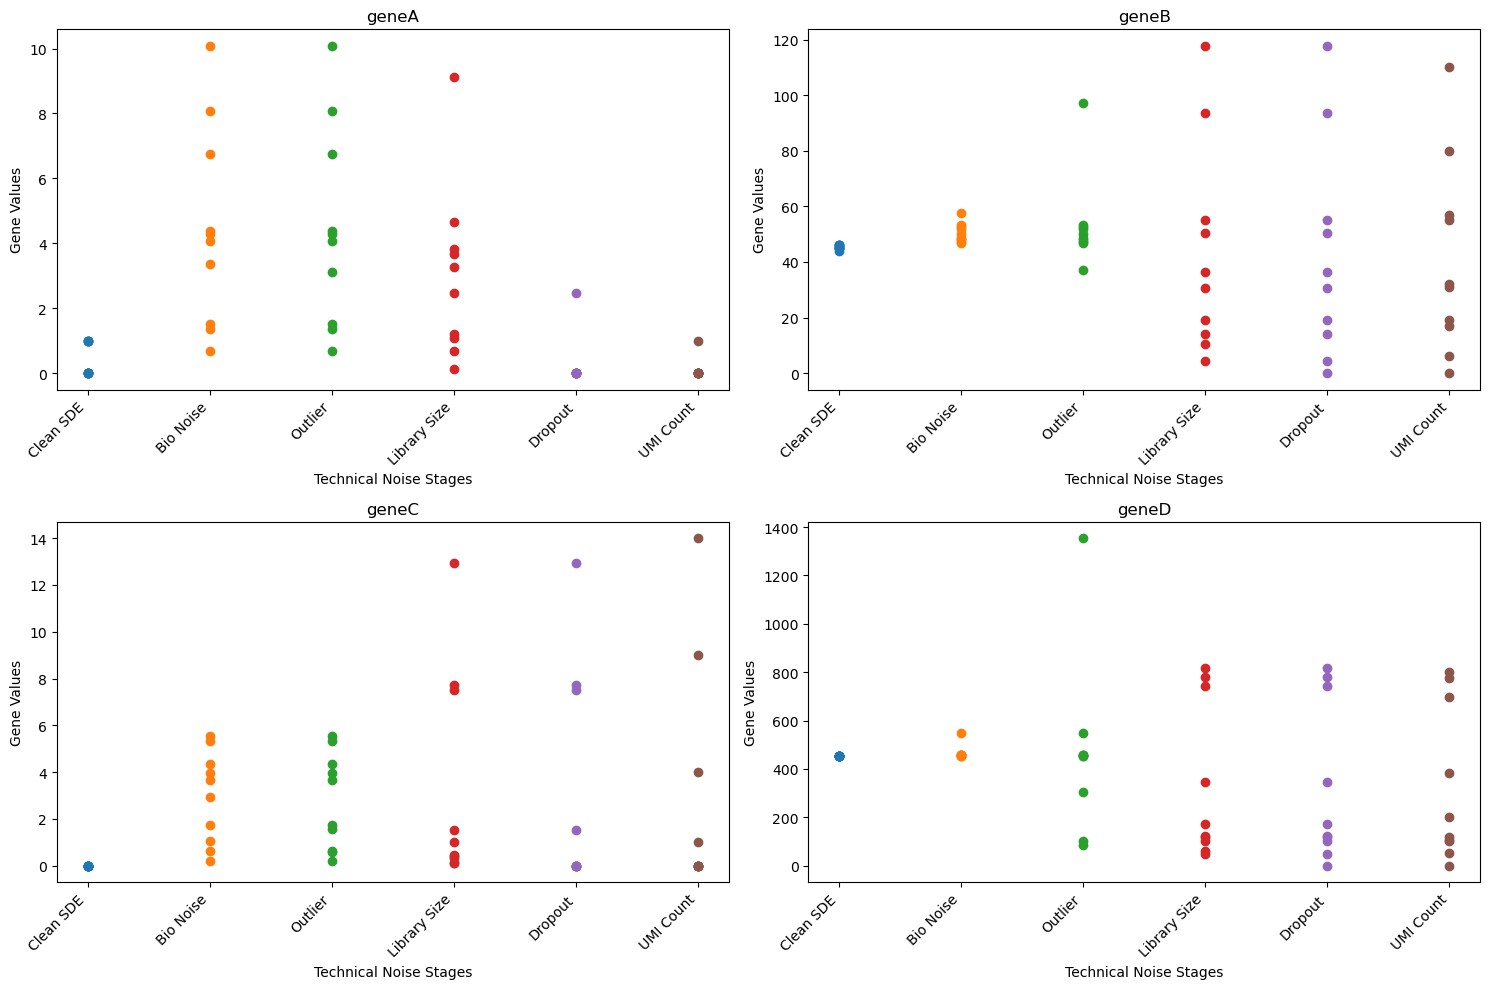

In [258]:
# Combine dataframes into a list for easier processing
dataframes = [clean_sde_samples_df, bio_noise_df, outliers_df, library_size_df, dropout_df, umi_count_df]
stages = ["Clean SDE", "Bio Noise", "Outlier", "Library Size", "Dropout", "UMI Count"]

genes = dataframes[0].columns
n_genes = len(genes)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, gene in enumerate(genes):
    for df, stage in zip(dataframes, stages):
        y_values = df[gene].values
        x_values = [stage] * len(y_values)
        axes[i].scatter(x_values, y_values, label=f'{stage}')
    
    axes[i].set_title(f'{gene}')
    axes[i].set_ylabel('Gene Values')
    axes[i].set_xlabel('Technical Noise Stages')
    axes[i].set_xticklabels(stages, rotation=45, ha="right")
    
plt.tight_layout()
plt.show()


note - a more realistic example would be 200 genes and 100 cells

Questions/comments:
1. how many cells do we have in the data? currently assume measurements from a single cell --> an expression table with N gene rows and 1 cell column
2. haven't integrated causal model and parameter uncertainty (chirho)
3. haven't integrated kinetics/numerical uncertainty, mass action may be too simplistic